In [1]:
import pandas as pd
import numpy as np
import warnings
import sys
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import csv
import matplotlib.lines as mlines


sys.path.append("..")
# sys.path.append(".")
from tool import market_dynamics_modeling_analysis
from tool import label_util as util
from comprehensive_evaluation.analyzer import *
from comprehensive_evaluation.util import *
from comprehensive_evaluation.slice_model import *
import bisect

In [2]:
positions = np.load("../best_result/BTCT/micro_action.npy")
data = pd.read_feather("../best_result/BTCT/test.feather")
path = "../best_result/BTCT/data"

isExist = os.path.exists(path)
if not isExist:
    os.makedirs(path)
    print("The new directory is created! {}".format(path))

max_holding_number1 = 0.01
commission_fee = 0

num_seg = 5
num_dynamics = 5
selected_timestamp = [
    pd.Timestamp(data[0:1]["timestamp"].values[0]),
    pd.Timestamp(data.iloc[-1]["timestamp"]),
]

In [3]:
def find_previous_element(sorted_list, value):
    index = bisect.bisect_left(sorted_list, value)
    if index == 0:
        return None  # 给定值小于列表中的所有元素
    else:
        return sorted_list[index - 1]

In [4]:
strategy = transform_market_order_strategy(
    data, positions, max_holding_number=max_holding_number1
)

In [5]:
selected_market = data[
    (data["timestamp"] >= selected_timestamp[0])
    & (data["timestamp"] <= selected_timestamp[1])
]

# model = Linear_Market_Dynamics_Model(
#     data=selected_market.reset_index(), dynamic_number=num_dynamics
# )
# model.run(path)

df_label = pd.read_feather(path + "/df_label.feather")

In [6]:
# def __init__(self, market_information, strategy,commission_rate=0.00015):

# market information should be a data frame that consist of 21 columns(timedstamp &  5-level ask bid's price and size)
# stategy: a list of dictionary consisting of 3 keys: timestamp, action (buy or sell) and dictionary indicating the level
# price and amount of the conducted orders

market_information = data
commission_rate = commission_fee
strategy = strategy

In [7]:
# def __init__(self, market_information, strategy,commission_rate=0.00015):

# market information should be a data frame that consist of 21 columns(timedstamp &  5-level ask bid's price and size)
# stategy: a list of dictionary consisting of 3 keys: timestamp, action (buy or sell) and dictionary indicating the level
# price and amount of the conducted orders

market_information = data
commission_rate = commission_fee
strategy = strategy

# order in strategy[{'timestamp':,'action':,'order':[{'price':,'amount':},{'price':,'amount':},...],'position':}]
# the strategy should be a list of market order containing the executed price, amount the agent's position after conducting the trade
# check the pricing the problem

price_timing = [price["timestamp"] for price in strategy]
assert max(price_timing) <= max(market_information.timestamp)
# check the price is legal
for timestamp in market_information.timestamp.unique():
    price_single_timestamp = market_information[
        market_information["timestamp"] == timestamp
    ]

    assert (
        price_single_timestamp["ask1_price"].values[0]
        >= price_single_timestamp["bid1_price"].values[0]
    )
# check the strategy opening position is whether is over rated and place correctly
# 对于买单我们要检查他的买入价格的下限应该符合ask1 price
for stack_order in strategy:
    timestamp = stack_order["timestamp"]
    current_market_information = market_information[
        market_information["timestamp"] == timestamp
    ]
    assert stack_order["action"] in ["buy", "sell"]
    if stack_order["action"] == "buy":
        list_order = stack_order["order"]
        level_number = len(list_order)
        for i in range(level_number):
            assert (
                list_order[i]["price"]
                == current_market_information["ask{}_price".format(i + 1)].values[0]
            )
            assert (
                list_order[i]["amount"]
                <= current_market_information["ask{}_size".format(i + 1)].values[0]
            )
    elif stack_order["action"] == "sell":
        list_order = stack_order["order"]
        level_number = len(list_order)
        for i in range(level_number):
            assert (
                list_order[i]["price"]
                == current_market_information["bid{}_price".format(i + 1)].values[
                    0
                ]  # ？？？？？？？？？bid0_price  format(i)
            )
            assert (
                list_order[i]["amount"]
                <= current_market_information["bid{}_size".format(i + 1)].values[0]
            )
# check the trace of the position in the trading process is legal or not. it always should be 0 at the start and end of the trading process
if strategy[-1]["position"] != 0:
    last_position = strategy[-1]["position"]
    warnings.warn(
        "the final position of the strategy is not zero, we force the agent to close its position in the last timestamp"
    )
    last_market_information = market_information[
        market_information["timestamp"] == max(market_information["timestamp"].unique())
    ]
    size_sum = 0
    if (
        last_position
        > last_market_information["bid1_size"].values[0]
        + last_market_information["bid2_size"].values[0]
        + last_market_information["bid3_size"].values[0]
        + last_market_information["bid4_size"].values[0]
        + last_market_information["bid5_size"].values[0]
    ):
        warnings.warn(
            "we barely trade at this timstamp instantly because there is no enough liquidity in the market,\
        we force the agent to close its position in the last timestamp by expanding the last level's size"
        )
        last_market_information["bid5_size"] = last_position - (
            last_market_information["bid1_size"].values[0]
            + last_market_information["bid2_size"].values[0]
            + last_market_information["bid3_size"].values[0]
            + last_market_information["bid4_size"].values[0]
        )
    for i in range(5):
        size_sum += last_market_information["bid{}_size".format(i + 1)].values[0]
        if last_position <= size_sum:
            break
    level_order_size_list = []
    order_remaining = last_position
    for j in range(i + 1):
        level_order_size_list.append(
            {
                "price": last_market_information["bid{}_price".format(j + 1)].values[0],
                "amount": min(
                    order_remaining,
                    last_market_information["bid{}_size".format(j + 1)].values[0],
                ),
            }
        )
        order_remaining = (
            order_remaining
            - last_market_information["bid{}_size".format(j + 1)].values[0]
        )
    strategy.append(
        {
            "timestamp": last_market_information["timestamp"].values[0],
            "action": "sell",
            "order": level_order_size_list,
            "position": 0,
        }
    )

In [8]:
def analysis_behavior(selected_strategy):
    # 现确定总共的开闭仓的次数 selected strategy 起码开头和结尾的position应该为0
    opening_strategy_timestamp_list = []
    closing_strategy_timestamp_list = []

    for stack_order in selected_strategy:
        if stack_order["action"] == "buy":
            order_size = 0
            for order in stack_order["order"]:
                order_size += order["amount"]
            if abs(order_size - stack_order["position"]) < 0.000001:
                opening_strategy_timestamp_list.append(stack_order["timestamp"])
        elif stack_order["action"] == "sell":
            if stack_order["position"] == 0:
                closing_strategy_timestamp_list.append(stack_order["timestamp"])
    # print("opening_strategy_timestamp_list", opening_strategy_timestamp_list)
    # print("closing_strategy_timestamp_list", closing_strategy_timestamp_list)
    assert len(opening_strategy_timestamp_list) == len(
        closing_strategy_timestamp_list
    )  # 确保开仓和平仓的次数相同
    trade_timestamp_list = list(
        zip(opening_strategy_timestamp_list, closing_strategy_timestamp_list)
    )

    # 1. 计算每次交易的收益率以及开仓到平仓的时间
    total_return_rate = 0
    total_duration = timedelta()
    total_mdd = 0
    count_pos_return_rate = 0

    for open_time, close_time in trade_timestamp_list:
        assert open_time < close_time
        single_trade_strategy = []
        for selected_stack_order in selected_strategy:
            if (
                selected_stack_order["timestamp"] >= open_time
                and selected_stack_order["timestamp"] <= close_time
            ):
                single_trade_strategy.append(selected_stack_order)
        cash_flow = []
        # print("single_trade_strategy", single_trade_strategy)
        # 计算每次交易的现金流的变化
        for stack_order in single_trade_strategy:
            # print("stack_order", stack_order)
            total_value = 0
            for order in stack_order["order"]:
                total_value += order["price"] * order["amount"]
            if stack_order["action"] == "buy":
                total_value = -total_value
                total_value = total_value * (1 + commission_rate)
            if stack_order["action"] == "sell":
                total_value = total_value * (1 - commission_rate)
            cash_flow.append(total_value)
        cash_record = [sum(cash_flow[: i + 1]) for i in range(len(cash_flow))]
        final_cash = cash_record[-1]
        require_money = -min(cash_record)
        # 计算每次交易的收益率和持仓时间
        return_rate = final_cash / require_money
        total_return_rate += return_rate

        if return_rate > 0:
            count_pos_return_rate += 1
            total_duration += close_time - open_time

        total_duration += close_time - open_time
        # TODO 根据bid1 price进行结算，每次持仓过程中的maxdrawdown
        position_record = []
        timestamp_record = []
        trade_position_record = []
        cash_accmulative_record = []
        for stack_order in single_trade_strategy:
            timestamp_record.append(stack_order["timestamp"])
            position_record.append(stack_order["position"])
        corresponding_market_timestamp = [
            timestamp
            for timestamp in market_information["timestamp"].unique()
            if timestamp >= open_time and timestamp <= close_time
        ]
        assert len(timestamp_record) == len(position_record)
        assert len(timestamp_record) == len(cash_record)

        for i in range(len(timestamp_record) - 1):
            time_point = [
                timestamp
                for timestamp in market_information["timestamp"].unique()
                if (
                    timestamp >= timestamp_record[i]
                    and timestamp < timestamp_record[i + 1]
                )
            ]
            # cash_accmulative_record.append(cash_record[i] + require_money)
            # for j in range(len(time_point)):
            #     trade_position_record.append(position_record[i])
            # for k in range(len(time_point)):
            #     cash_accmulative_record.append(cash_accmulative_record[-1])
            for j in range(len(time_point)):
                trade_position_record.append(position_record[i])
            for k in range(len(time_point)):
                cash_accmulative_record.append(cash_record[i] + require_money)

        trade_position_record.append(0)
        cash_accmulative_record.append(cash_record[i + 1] + require_money)
        # print("cash_accmulative_record", cash_accmulative_record)

        # trade_position_record.append(0)
        corresponding_market_information = market_information[
            market_information["timestamp"].isin(corresponding_market_timestamp)
        ]
        # print("trade_position_record_length", len(trade_position_record))
        # print("corresponding_market_information_length", len(corresponding_market_information))
        # if len(trade_position_record) != len(corresponding_market_information):
        #     print("trade_position_record", trade_position_record)
        #     print("corresponding_market_information", corresponding_market_information)

        assert len(trade_position_record) == len(corresponding_market_information)

        position_value_record = [
            position * single_value
            for position, single_value in zip(
                trade_position_record,
                corresponding_market_information["bid1_price"].values,
            )
        ]
        total_value_record = [
            cash + position_value
            for cash, position_value in zip(
                cash_accmulative_record, position_value_record
            )
        ]
        mdd = 0
        peak = total_value_record[0]
        for value in total_value_record:
            if value > peak:
                peak = value
            dd = (peak - value) / peak
            if dd > mdd:
                mdd = dd
        total_mdd += mdd

    mean_return_rate = total_return_rate / len(trade_timestamp_list)
    mean_duration = total_duration / len(trade_timestamp_list)
    mean_mdd = total_mdd / len(trade_timestamp_list)
    # TODO 你还需要计算这段策略中的胜率（trade中return rate大于0的数量/trade的总数量）
    win_rate = count_pos_return_rate / len(trade_timestamp_list)
    return mean_return_rate, mean_duration, mean_mdd, win_rate

In [9]:
def calculate_metric(selected_timestamp: list):
    # selected trade is part of the strategy that we want to calculate the metric,
    # its position do not have to end or start with 0
    # selected_timestamp is a 2-element list indicating the start and end of the timestamp
    selected_timestamp.sort()
    assert len(selected_timestamp) == 2
    selected_market = market_information[
        (market_information["timestamp"] >= selected_timestamp[0])
        & (market_information["timestamp"] <= selected_timestamp[1])
    ]
    selected_strategy = [
        item
        for item in strategy
        if selected_timestamp[0] <= item["timestamp"] <= selected_timestamp[1]
    ]
    if not selected_strategy:
        # 检查上一个最近的交易，和结尾最近的
        # 开头的position，和结尾的position减去当次交易的， 应该相等  加assert abs(-)
        # if position < abs(-) : 000
        # else: 和market一样
        pos_before = 0
        pos_end = 0
        flag = 0
        for i, strat in enumerate(strategy):
            if flag == 0:
                if strat['timestamp'] > selected_timestamp[0]:
                    if i > 0:
                        strat_before = strategy[i-1]
                        pos_before = strat_before["position"]
                    flag = 1
            else:
                pos_end = pos_before
                if strat['timestamp'] > selected_timestamp[1]:
                    strat_after = strategy[i-1]
                    pos_end = strat_after["position"]
                    if strat_after['action'] == 'buy':
                        for order in strat_after['order']:
                            pos_end -= order['amount']
                    elif strat_after['action'] == 'sell':
                        for order in strat_after['order']:
                            pos_end += order['amount']
                break 
        assert ( abs(pos_before - pos_end) < 1e-5 )
        if pos_before < 1e-5:
            return 0,0,0
        else:
            return 1,1,1
    
    first_trade = selected_strategy[0]
    first_trade_size = sum([level["amount"] for level in first_trade["order"]])
    if first_trade["action"] == "buy":
        first_trade_size = -first_trade_size
    initial_posotion = selected_strategy[0]["position"] + first_trade_size
    # print(selected_strategy[0])
    # print(first_trade_size)
    # print(initial_posotion)
    assert initial_posotion >= -1e-5       #TODO
    
    # 默认第一步自动补仓 用bid1买的 看啥情况
    cash_flow = [
        -initial_posotion
        * market_information[market_information["timestamp"] == selected_timestamp[0]][
            "bid1_price"
        ].values[0]
    ]
    for stack_order in selected_strategy:
        total_value = 0
        for order in stack_order["order"]:
            total_value += order["price"] * order["amount"]
            if stack_order["action"] == "buy":
                total_value = -total_value
                total_value = total_value * (1 + commission_rate)
            if stack_order["action"] == "sell":
                total_value = total_value * (1 - commission_rate)
            cash_flow.append(total_value)
            cash_flow.append(total_value)

    cash_record = [sum(cash_flow[: i + 1]) for i in range(len(cash_flow))]
    # print("cash_record", cash_record)
    # cash record 总计来讲现金流的list
    require_money = -min(cash_record)
    # 最小的现金流 （最缺钱的 就是require money）
    position = initial_posotion
    position_market_record = []
    cash_market_record = []
    for timestamp in selected_market.timestamp.unique():
        matching_strategy = None
        for item in selected_strategy:
            if item["timestamp"] == timestamp:
                matching_strategy = item
                break
        if matching_strategy:
            current_position = matching_strategy["position"]
            position = current_position
        else:
            current_position = position
        position_market_record.append(current_position)
    inital_cash = require_money - cash_flow[0]
    cash = inital_cash
    for timestamp in selected_market.timestamp.unique():
        matching_strategy = next(
            (item for item in selected_strategy if item["timestamp"] == timestamp),
            None,
        )
        if matching_strategy:
            total_value = 0
            for order in matching_strategy["order"]:
                total_value += order["price"] * order["amount"]
            if matching_strategy["action"] == "buy":
                total_value = -total_value
                total_value = total_value * (1 + commission_rate)
            if matching_strategy["action"] == "sell":
                total_value = total_value * (1 - commission_rate)
            cash_flow.append(total_value)
            current_cash = cash + total_value
            cash = current_cash
            # print('total_value',total_value)
        else:
            current_cash = cash
        # print("current_cash", current_cash)
        cash_market_record.append(current_cash)
    assert len(position_market_record) == len(cash_market_record)
    # print(len(selected_market))
    # print(len(position_market_record))
    assert len(position_market_record) == len(selected_market)
    selected_market_price = selected_market["bid1_price"].values
    position_value_record = [
        position * single_value
        for position, single_value in zip(position_market_record, selected_market_price)
    ]
    # print("require_money", require_money)

    total_value_record = [
        cash + position_value
        for cash, position_value in zip(cash_market_record, position_value_record)
    ]
    # print("cash", cash_market_record)
    tr = total_value_record[-1] / total_value_record[0] - 1
    mdd = 0
    peak = total_value_record[0]
    for value in total_value_record:
        if value > peak:
            peak = value
        dd = (peak - value) / peak
        if dd > mdd:
            mdd = dd
    cr = tr / mdd
    return tr, mdd, cr

In [10]:
def calculate_metric_market(selected_timestamp: list):
    # selected trade is part of the strategy that we want to calculate the metric,
    # its position do not have to end or start with 0
    # selected_timestamp is a 2-element list indicating the start and end of the timestamp
    global df_label
    
    selected_timestamp.sort()
    assert len(selected_timestamp) == 2
    selected_market = df_label[
        (df_label["timestamp"] >= selected_timestamp[0])
        & (df_label["timestamp"] <= selected_timestamp[1])
    ]
    assets = selected_market['bid1_price'].values
    tr = assets[-1] / (assets[0]) - 1
    mdd = 0
    peak=assets[0]
    for value in assets:
        if value>peak:
            peak=value
        dd=(peak-value)/peak
        if dd>mdd:
            mdd=dd
    cr = tr / (mdd + 1e-10)
    return tr, mdd, cr


# selected_timestamp = [pd.Timestamp('2023-05-06 14:48:21'),pd.Timestamp('2023-05-07 01:28:26')]
tr, mdd, cr = calculate_metric_market( selected_timestamp)
print( tr)
print( mdd)
print(cr)

-0.051578956182204205
0.11455511189831125
-0.45025451315489595


In [11]:
def analysis_along_dynamics(path, selected_timestamp: list):
    # TODO 根据label切成小段
    # TODO 对每个小段， 调用 cal_metric，cal_metric_market
    # TODO 保存下来，针对每个label/dynamics
    # TODO 求均值
    
    selected_market = df_label[
        (df_label["timestamp"] >= selected_timestamp[0])
        & (df_label["timestamp"] <= selected_timestamp[1])
    ]
    
    labels = selected_market['label'].values
    timeframes = []
    index = 1
    startIndex = 0
    while index < len(labels):
        if labels[index] == labels[index-1]:
            pass
        else:
            timeframes.append([startIndex,index-1])
            startIndex = index
        index += 1
    timeframes.append([startIndex,index-1])

    metric_market  = [[[] for i in range(5)] for j in range(3)]
    metric_strategy =  [[[] for i in range(5)] for j in range(3)]

    for [istart,iend] in timeframes:
        selected_local_timestamp = [df_label.iloc[istart]['timestamp'],df_label.iloc[iend]['timestamp']]
        ilabel = df_label.iloc[istart]['label']
        # print(selected_local_timestamp)
        tr1, mdd1, cr1 = calculate_metric_market(selected_local_timestamp)
        metric_market[0][ilabel].append(tr1)
        metric_market[1][ilabel].append(mdd1)
        metric_market[2][ilabel].append(cr1)
        tr2, mdd2, cr2 = calculate_metric(selected_local_timestamp)
        if tr2==mdd2==cr2==0: 
            metric_strategy[0][ilabel].append(0)
            metric_strategy[1][ilabel].append(0)
            metric_strategy[2][ilabel].append(0)   
            # print("case1")
        elif tr2==mdd2==cr2==1:
            metric_strategy[0][ilabel].append(tr1)
            metric_strategy[1][ilabel].append(mdd1)
            metric_strategy[2][ilabel].append(cr1)   
            # print("case2")          
        else:
            metric_strategy[0][ilabel].append(tr2)
            metric_strategy[1][ilabel].append(mdd2)
            metric_strategy[2][ilabel].append(cr2)  
     
    metric_market_avg =  [[0 for i in range(5)] for j in range(3)]
    metric_strategy_avg =  [[0 for i in range(5)] for j in range(3)]
    for i in range(3):
        for j in range(5):
            metric_market_avg[i][j] = sum(metric_market[i][j])/len(metric_market[i][j])
            metric_strategy_avg[i][j] = sum(metric_strategy[i][j])/len(metric_strategy[i][j])
    metric_namelist = ['tr','mdd','cr']
    for i in range(3):
        metric_strategy_avg[i].insert(0,metric_namelist[i])
        metric_market_avg[i].insert(0,metric_namelist[i])
    metrics_path1 = path + "/metrics_dynamics_market".format(i) + ".csv"
    metrics_path2 = path + "/metrics_dynamics_strategy".format(i) + ".csv"
    fields = ['metric','dynamics 0','dynamics 1','dynamics 2','dynamics 3','dynamics 4']
    with open(metrics_path1, "w") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(fields)
        writer.writerows(metric_market_avg)
    with open(metrics_path2, "w") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(fields)
        writer.writerows(metric_strategy_avg)
    
    return metric_market_avg,metric_strategy_avg, metric_market,metric_strategy
      
  
# selected_timestamp = [pd.Timestamp('2023-05-06 14:48:21'),pd.Timestamp('2023-05-07 01:28:26')]
selected_timestamp = [
    pd.Timestamp(data[0:1]["timestamp"].values[0]),
    pd.Timestamp(data.iloc[-1]["timestamp"]),
]
num_dynamics = 5
metric_market_avg,metric_strategy_avg,metric_market,metric_strategy = analysis_along_dynamics(path,selected_timestamp)
print(metric_market_avg)
print(metric_strategy_avg)

/tmp/ipykernel_1272878/1743977239.py:147: RuntimeWarning: invalid value encountered in scalar divide
  cr = tr / mdd


[['tr', -0.0027846389019537177, -0.0010863877524719668, 9.868105403440375e-05, 0.0011670476435693285, 0.002471319053566576], ['mdd', 0.003409910140760327, 0.0014663335459250278, 0.0009581890827856526, 0.00047607440081977797, 0.0007893571357727114], ['cr', -0.805314474248359, -0.736052806810462, 0.3323805089922913, 3.307327405839939, 4.355884588597449]]
[['tr', -0.0015502329282788521, -0.0006463994108614914, 6.122700180333746e-05, 0.0007239088230655034, 0.0015937043852698534], ['mdd', 0.0019412254409809126, 0.0008819526739332769, 0.0005326486379017764, 0.00031247609242636036, 0.0005378424269952697], ['cr', -0.5327215935027982, -0.44525335511898007, nan, 1.9030850416267087, 3.0139579337351865]]


In [12]:
df_label[df_label["timestamp"]==pd.Timestamp('2023-05-15 19:45:51')]

,index,timestamp,symbol,ask1_price,ask1_size,bid1_price,bid1_size,ask2_price,ask2_size,bid2_price,...,qtld_60_m,imax_60_m,imin_60_m,imxd_60_m,imxd_60_dis_m,tic,pct_return,key_indicator_filtered,pct_return_filtered,label
796179,796179,2023-05-15 19:45:51,BTCTUSD,27405.95,0.01127,27402.2,0.06525,27405.98,0.08658,27402.19,...,-0.409537,0.066667,0.666667,-0.6,0.0,BTCTUSD,-0.000476,27408.56632,-0.000012,1


In [13]:
# # def draw_trend_graph(path, selected_timestamp: list):

# selected_market = df_label[
#     (df_label["timestamp"] >= selected_timestamp[0])
#     & (df_label["timestamp"] <= selected_timestamp[1])
# ]
# labels = selected_market['label'].values
# timeframes = []
# index = 1
# startIndex = 0
# while index < len(labels):
#     if labels[index] == labels[index-1]:
#         pass
#     else:
#         timeframes.append([startIndex,index-1])
#         startIndex = index
#     index += 1
# timeframes.append([startIndex,index-1])

# spread = (selected_market['ask1_price']/ selected_market['bid1_price'] -1)*100
# spread 

In [14]:
# from matplotlib.ticker import ScalarFormatter

# x = selected_market['timestamp']

# fig, ax = plt.subplots(figsize=(24, 12))
# ax.plot(x,spread)

# formatter = ScalarFormatter(useMathText=True)
# formatter.set_scientific(True)
# formatter.set_powerlimits((-1, 1))  # 设置指数部分的显示范围
# # ax.xaxis.set_major_formatter(formatter)

# color_list = ['#EF8383', '#F0C48B', '#A5D89C', '#9CD4D8', '#CA9CD8', '#000000']
# plt.subplots_adjust(hspace=0.3)
# plt.tight_layout(pad=1.5,rect=[0, 0, 1, 0.88])
# plt.show()

In [15]:
def analysis_along_time_dynamics(path, num_dynamics, num_seg, selected_timestamp: list):
    # TODO 给定段时间，先把这段时间内的市场状态划分成num_dynamics个市场状态
    # TODO 根据策略 用开平仓的次数来划分时间（总开平仓次数）
    # TODO 两维度从时间和市场状态 计算胜率，收益率，持仓时间，最大回撤，calmar ratio，已经开仓量和平仓量占总开仓量和平仓量的百分比

    selected_market = data[
        (data["timestamp"] >= selected_timestamp[0])
        & (data["timestamp"] <= selected_timestamp[1])
    ]

    print(len(selected_market))
    print(len(df_label))
    assert len(selected_market) == len(df_label)

    opening_count_seg = [[0] * num_dynamics] * num_seg
    closing_count_seg = [[0] * num_dynamics] * num_seg
    opening_amount_seg = [[0] * num_dynamics] * num_seg
    closing_amount_seg = [[0] * num_dynamics] * num_seg

    opening_strategy_timestamp_list = []
    closing_strategy_timestamp_list = []

    for stack_order in strategy:
        # print(stack_order)
        if stack_order["action"] == "buy":
            order_size = 0
            for order in stack_order["order"]:
                order_size += order["amount"]
            if abs(order_size - stack_order["position"]) < 1e-5:
                # print("add buy/opening record {}".format(stack_order["timestamp"]))
                opening_strategy_timestamp_list.append(stack_order["timestamp"])
        elif stack_order["action"] == "sell":
            if stack_order["position"] == 0:
                closing_strategy_timestamp_list.append(stack_order["timestamp"])
                # print("add sell/closing record {}".format(stack_order["timestamp"]))

    assert len(opening_strategy_timestamp_list) == len(closing_strategy_timestamp_list)
    # print(len(opening_strategy_timestamp_list))
    assert len(opening_strategy_timestamp_list) >= num_seg
    num_trade_seg = int(len(opening_strategy_timestamp_list) / num_seg)
    
    metrics = []
    
    def calculate(local_selected_timestamp):
        tr, mdd, cr = calculate_metric(local_selected_timestamp)
        selected_strategy = [  # 进行交易的market time
            item
            for item in strategy
            if local_selected_timestamp[0]
            <= item["timestamp"]
            <= local_selected_timestamp[1]
        ]
        mean_return_rate, mean_duration, mean_mdd, win_rate = analysis_behavior(
            selected_strategy
        )

        print(
            "in the {}th segment, the total return rate is {}, the max drawdown is {}, the calmar ratio is {}, the mean return rate, mean duration, mean max drawdown, win rate is as follow: {}, {}, {}, {}".format(
                i, tr, mdd, cr, mean_return_rate, mean_duration, mean_mdd, win_rate
            )
        )

        metrics.append(
            {
                "segmentId": i,
                "total return rate": tr,
                "max drawdown": mdd,
                "calmar ratio": cr,
                "mean return rate": mean_return_rate,
                "mean duration": mean_duration,
                "mean max drawdown": mean_mdd,
                "win rate": win_rate,
            }
        )


    def along_dynamics(local_selected_timestamp, index_seg):
        # selected_market = data[
        #     (data["timestamp"] >= local_selected_timestamp[0])
        #     & (data["timestamp"] <= local_selected_timestamp[1])
        # ]
        selected_strategy = [  # 进行交易的market time
            item
            for item in strategy
            if local_selected_timestamp[0]
            <= item["timestamp"]
            <= local_selected_timestamp[1]
        ]

        opening_strategy_timestamp_list = []
        closing_strategy_timestamp_list = []
        opening_count = [0] * 5
        closing_count = [0] * 5
        opening_amount = [0] * 5
        closing_amount = [0] * 5

        for stack_order in selected_strategy:
            # print(stack_order)
            if stack_order["action"] == "buy":
                order_size = 0
                for order in stack_order["order"]:
                    order_size += order["amount"]
                label_index = df_label[
                    df_label["timestamp"] == stack_order["timestamp"]
                ]["label"].values[
                    0
                ]  # 获取label
                opening_amount[label_index] += sum(
                    level["amount"] for level in stack_order["order"]
                )  # 记录开仓总量至对应label
                if abs(order_size - stack_order["position"]) < 0.000001:
                    # print(stack_order["timestamp"])
                    opening_strategy_timestamp_list.append(stack_order["timestamp"])
                    opening_count[label_index] += 1  # 记录对应label的开仓次数
                    # print("add buy count {} for label {}".format(opening_count[label_index], label_index))
                # sumtemp = sum( level['amount'] for level in stack_order['order'])
                # print("add buy amount {} for label {}".format(sumtemp, label_index))

            elif stack_order["action"] == "sell":
                label_index = df_label[
                    df_label["timestamp"] == stack_order["timestamp"]
                ]["label"].values[0]
                closing_amount[label_index] += sum(
                    level["amount"] for level in stack_order["order"]
                )
                if stack_order["position"] == 0:
                    # print(stack_order["timestamp"])
                    closing_strategy_timestamp_list.append(stack_order["timestamp"])
                    closing_count[label_index] += 1
                    # print("add sell count {} for label {}".format(closing_count[label_index], label_index))
                # sumtemp = sum( level['amount'] for level in stack_order['order'])
                # print("add sell record {} for label {}".format(sumtemp, label_index))
                
        opening_count_seg[index_seg] = opening_count
        closing_count_seg[index_seg] = closing_count
        opening_amount_seg[index_seg] = opening_amount
        closing_amount_seg[index_seg] = closing_amount

    for i in range(num_seg):
        # print()
        # print("this is segment {}".format(i))
        start_market_time = 0
        if i == 0:
            start_market_time = opening_strategy_timestamp_list[num_trade_seg * 0]
        else:
            for row_index, row in data.iterrows():
                if (
                    row["timestamp"]
                    > closing_strategy_timestamp_list[num_trade_seg * i]
                ):
                    start_market_time = row["timestamp"]
                    break

        if i == num_seg - 1:
            close_market_time = closing_strategy_timestamp_list[-1]
        else:
            close_market_time = closing_strategy_timestamp_list[num_trade_seg * (i + 1)]

        phase_selected_timestamp = [start_market_time, close_market_time]
        calculate(phase_selected_timestamp)
        along_dynamics(phase_selected_timestamp, i)    
    
    metrics_path = path + "/metrics_segment.csv"
    metrics_name = [
        "segmentId",
        "total return rate",
        "max drawdown",
        "calmar ratio",
        "mean return rate",
        "mean duration",
        "mean max drawdown",
        "win rate",
    ]
    with open(metrics_path, "w") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=metrics_name)
        writer.writeheader()
        writer.writerows(metrics)
        
    return (
        opening_count_seg,
        closing_count_seg,
        opening_amount_seg,
        closing_amount_seg,
    )

In [16]:
num_seg = 5
(
    opening_count_seg,
    closing_count_seg,
    opening_amount_seg,
    closing_amount_seg,
) = analysis_along_time_dynamics(path, num_dynamics, num_seg, selected_timestamp)

811428
811428
in the 0th segment, the total return rate is -0.0016428607196137257, the max drawdown is 0.014768218766893706, the calmar ratio is -0.11124298370339479, the mean return rate, mean duration, mean max drawdown, win rate is as follow: -0.0001307384104196366, 0 days 01:45:15, 0.004536741258023474, 0.35294117647058826
in the 1th segment, the total return rate is -0.0042816135526190235, the max drawdown is 0.015874385008875985, the calmar ratio is -0.2697183891045232, the mean return rate, mean duration, mean max drawdown, win rate is as follow: -0.0005370332698191904, 0 days 01:52:42.187500, 0.006180155573767092, 0.375
in the 2th segment, the total return rate is 0.018006462509710497, the max drawdown is 0.012058362655733072, the calmar ratio is 1.493275913471506, the mean return rate, mean duration, mean max drawdown, win rate is as follow: 0.0022579464672983014, 0 days 02:14:21.562500, 0.005538933479145671, 0.75
in the 3th segment, the total return rate is -0.028211753496778

In [17]:
saves = ["oc", "cc", "oa", "ca"]
temp = [opening_count_seg, closing_count_seg, opening_amount_seg, closing_amount_seg]
for i in temp:
    print(i)

[[4, 2, 3, 4, 4], [4, 1, 3, 6, 2], [5, 1, 3, 3, 4], [1, 6, 4, 4, 1], [3, 3, 7, 2, 4]]
[[5, 2, 5, 2, 3], [1, 5, 7, 1, 2], [4, 6, 4, 1, 1], [3, 4, 4, 3, 2], [3, 2, 9, 2, 3]]
[[0.04, 0.0225, 0.035, 0.04, 0.03], [0.04, 0.0225, 0.035, 0.060000000000000005, 0.02], [0.05, 0.0225, 0.0325, 0.03, 0.0425], [0.0075, 0.065, 0.0425, 0.04, 0.01], [0.0225, 0.035, 0.0675, 0.02, 0.0325]]
[[0.05, 0.0225, 0.055, 0.02, 0.02], [0.01, 0.065, 0.07250000000000001, 0.01, 0.02], [0.04, 0.07250000000000001, 0.0425, 0.01, 0.0125], [0.027500000000000004, 0.045000000000000005, 0.05, 0.0225, 0.02], [0.0225, 0.0325, 0.07250000000000001, 0.0275, 0.0225]]


In [18]:
for i, save in enumerate(saves):
    path_save = path + "/" + save + ".npy"
    array_data = np.array(temp[i])
    np.save(path_save, array_data)

In [19]:
read_rlt = []
saves = ["oc", "cc", "oa", "ca"]
for i, save in enumerate(saves):
    path_save = path + "/" + save + ".npy"
    read_rlt.append(np.load(path_save))
    read_rlt[i] = read_rlt[i].tolist()
print(read_rlt)
opening_count_seg = read_rlt[0]
closing_count_seg = read_rlt[1]
opening_amount_seg = read_rlt[2]
closing_amount_seg = read_rlt[3]

[[[4, 2, 3, 4, 4], [4, 1, 3, 6, 2], [5, 1, 3, 3, 4], [1, 6, 4, 4, 1], [3, 3, 7, 2, 4]], [[5, 2, 5, 2, 3], [1, 5, 7, 1, 2], [4, 6, 4, 1, 1], [3, 4, 4, 3, 2], [3, 2, 9, 2, 3]], [[0.04, 0.0225, 0.035, 0.04, 0.03], [0.04, 0.0225, 0.035, 0.060000000000000005, 0.02], [0.05, 0.0225, 0.0325, 0.03, 0.0425], [0.0075, 0.065, 0.0425, 0.04, 0.01], [0.0225, 0.035, 0.0675, 0.02, 0.0325]], [[0.05, 0.0225, 0.055, 0.02, 0.02], [0.01, 0.065, 0.07250000000000001, 0.01, 0.02], [0.04, 0.07250000000000001, 0.0425, 0.01, 0.0125], [0.027500000000000004, 0.045000000000000005, 0.05, 0.0225, 0.02], [0.0225, 0.0325, 0.07250000000000001, 0.0275, 0.0225]]]


In [20]:
opening_count = [sum(seg) for seg in opening_count_seg]
closing_count = [sum(seg) for seg in closing_count_seg]
opening_amount = [sum(seg) for seg in opening_amount_seg]
closing_amount = [sum(seg) for seg in closing_amount_seg]


opening_count_perc = [
    [float(format(x / sum(opening_count), ".3f")) for x in opening_count]
    for opening_count in opening_count_seg
]
closing_count_perc = [
    [float(format(x / sum(closing_count), ".3f")) for x in closing_count]
    for closing_count in closing_count_seg
]
opening_amount_perc = [
    [float(format(x / sum(opening_amount), ".3f")) for x in opening_amount]
    for opening_amount in opening_amount_seg
]
closing_amount_perc = [
    [float(format(x / sum(closing_amount), ".3f")) for x in closing_amount]
    for closing_amount in closing_amount_seg
]

In [21]:
opening_count_perc

[[0.235, 0.118, 0.176, 0.235, 0.235],
 [0.25, 0.062, 0.188, 0.375, 0.125],
 [0.312, 0.062, 0.188, 0.188, 0.25],
 [0.062, 0.375, 0.25, 0.25, 0.062],
 [0.158, 0.158, 0.368, 0.105, 0.211]]

In [22]:
closing_count_perc

[[0.294, 0.118, 0.294, 0.118, 0.176],
 [0.062, 0.312, 0.438, 0.062, 0.125],
 [0.25, 0.375, 0.25, 0.062, 0.062],
 [0.188, 0.25, 0.25, 0.188, 0.125],
 [0.158, 0.105, 0.474, 0.105, 0.158]]

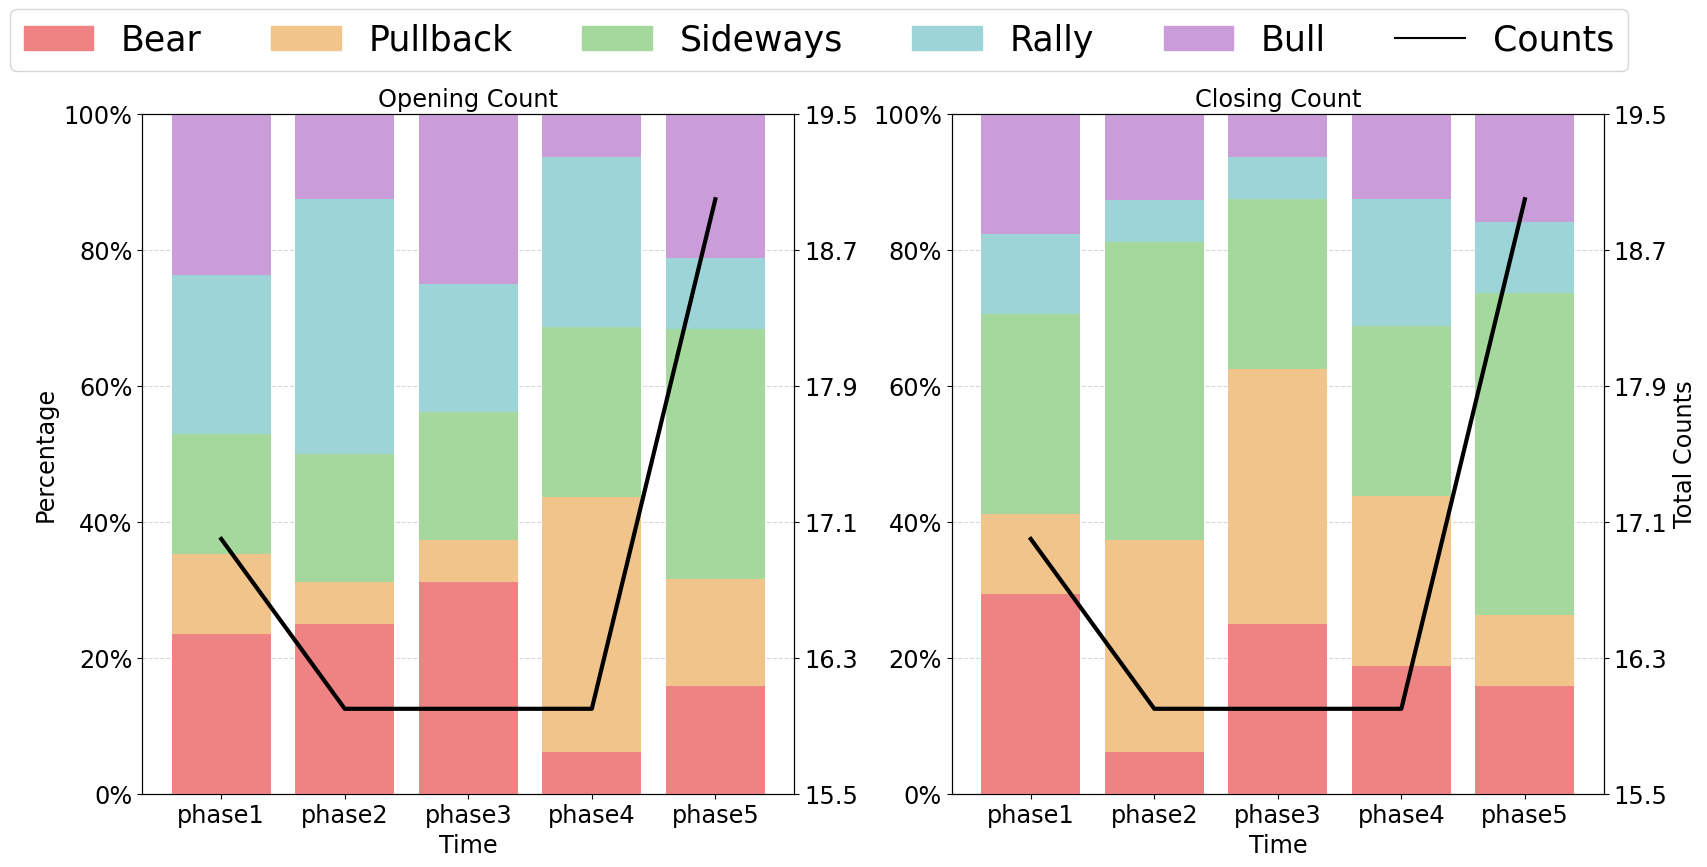

In [23]:
# color_list = ["#8ECFC9", "#FFBE7A", "#FA7F6F", "#BEB8DC", "#F8AC8C", "#2878B5"]
color_list = ['#EF8383', '#F0C48B', '#A5D89C', '#9CD4D8', '#CA9CD8', '#000000']


x_label = ["phase1", "phase2", "phase3", "phase4", "phase5"]
y_label = ["Bull", "Rally", "Sideways", "Pullback", "Bear"]
y_label.reverse()
legend_label = ["Counts", "Bull", "Rally", "Sideways", "Pullback", "Bear"]
legend_label.reverse()
opening_close_count = [opening_count, closing_count]
opening_close_perc = [opening_count_perc, closing_count_perc]
graph_names = ["Opening Count", "Closing Count"]

x_ax = np.array(range(len(x_label))) * 2.5

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

patches = [
    mpatches.Patch(color=color_list[i], label="{:s}".format(legend_label[i]))
    for i in range(len(color_list)-1)
]
patches.append(mlines.Line2D([], [], color=color_list[-1], label=legend_label[-1]))
# ax = plt.gca()
# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width, box.height * 0.75])
legend = fig.legend(
    handles=patches,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.1),
    ncol=6,
    fontsize=25,
    
)

for subplot in range(1, 3):
    ax = axes[subplot - 1]
    # # plt.subplot(1,2,subplot)
    # figure, ax1 = plt.subplots()
    ax.set_xlabel("Time", fontsize="xx-large")
    if subplot == 1:
        ax.set_ylabel("Percentage", fontsize="xx-large")
    ax.set_title(graph_names[subplot - 1], fontsize="xx-large")
    bottom_y = np.zeros(5)
    for i in range(5):
        ax.bar(
            x_ax,
            [count[i] for count in opening_close_perc[subplot - 1]],
            label=y_label[i],
            width=2,
            color=color_list[i],
            bottom=bottom_y,
            zorder = 5
        )
        for k in range(len(bottom_y)):
            bottom_y[k] = bottom_y[k] + opening_close_perc[subplot - 1][k][i]
    ax.set_xticks([i for i in x_ax], x_label, fontsize="xx-large")
    ax.set_ylim(0, 1.0)
    ax.set_yticks(np.arange(0, 1.2, 0.2), [f"{i}%" for i in range(0, 120, 20)], fontsize="xx-large")
    ax.grid(axis="y", alpha=0.5, ls="--", zorder = 0)
    plt.tight_layout()

    ax2 = ax.twinx()
    ax2.plot(x_ax, opening_close_count[subplot - 1], color=color_list[-1], linewidth=3)
    if subplot == 2:
        ax2.set_ylabel("Total Counts", fontsize="xx-large")
    ax2.tick_params(axis='y',labelsize="xx-large")
    ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))

img_path = path + "/phase_dynamic_proportion.pdf"
plt.savefig(img_path, bbox_inches="tight")
plt.show()

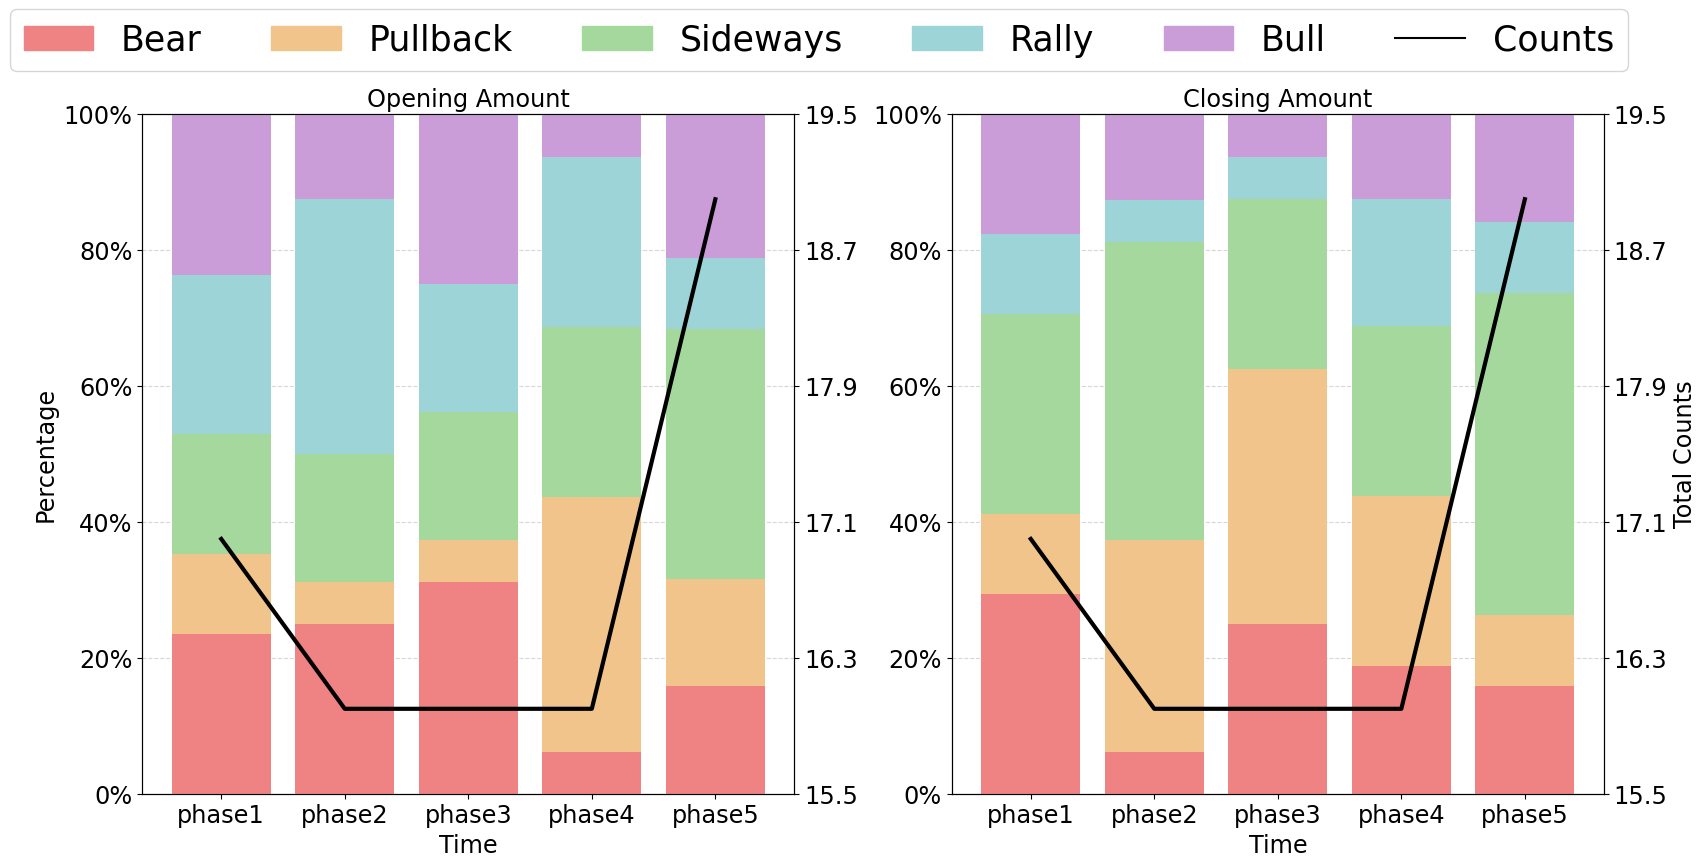

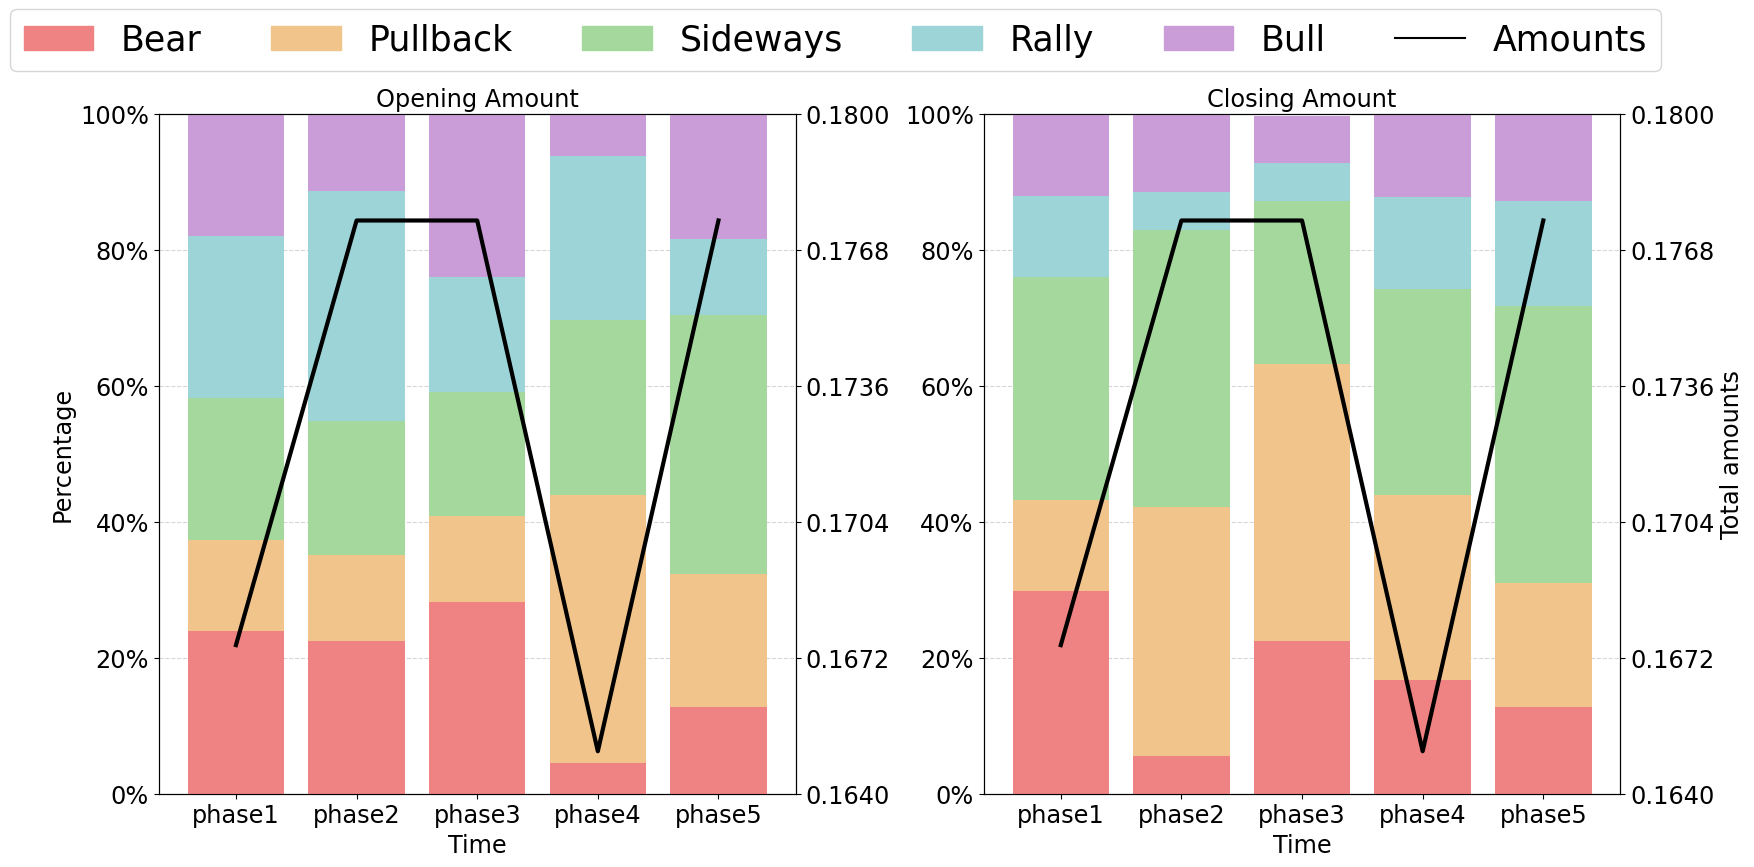

In [29]:
def draw_stacking_graph(opening_count_seg,closing_count_seg,opening_amount_seg,closing_amount_seg):
  opening_count = [sum(seg) for seg in opening_count_seg]
  closing_count = [sum(seg) for seg in closing_count_seg]
  opening_amount = [sum(seg) for seg in opening_amount_seg]
  closing_amount = [sum(seg) for seg in closing_amount_seg]


  opening_count_perc = [
      [float(format(x / sum(opening_count), ".3f")) for x in opening_count]
      for opening_count in opening_count_seg
  ]
  closing_count_perc = [
      [float(format(x / sum(closing_count), ".3f")) for x in closing_count]
      for closing_count in closing_count_seg
  ]
  opening_amount_perc = [
      [float(format(x / sum(opening_amount), ".3f")) for x in opening_amount]
      for opening_amount in opening_amount_seg
  ]
  closing_amount_perc = [
      [float(format(x / sum(closing_amount), ".3f")) for x in closing_amount]
      for closing_amount in closing_amount_seg
  ]     
  
  color_list = ['#EF8383', '#F0C48B', '#A5D89C', '#9CD4D8', '#CA9CD8', '#000000']
  x_label = ["phase1", "phase2", "phase3", "phase4", "phase5"]
  y_label = ["Bull", "Rally", "Sideways", "Pullback", "Bear"]
  y_label.reverse()
  
  x_ax = np.array(range(len(x_label))) * 2.5

  legend_label_count = ["Counts", "Bull", "Rally", "Sideways", "Pullback", "Bear"]
  legend_label_count.reverse()
  graph_names_count = ["Opening Amount", "Closing Amount"]
  opening_close_count = [opening_count, closing_count]
  opening_close_count_perc = [opening_count_perc, closing_count_perc]  
  
  legend_label_amount = ["Amounts", "Bull", "Rally", "Sideways", "Pullback", "Bear"]
  legend_label_amount.reverse()
  graph_names_amount = ["Opening Amount", "Closing Amount"]  
  opening_close_amount = [opening_amount, closing_amount]
  opening_close_amount_perc = [opening_amount_perc, closing_amount_perc]
  
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
  patches = [
      mpatches.Patch(color=color_list[i], label="{:s}".format(legend_label_count[i]))
      for i in range(len(color_list)-1)
  ]
  patches.append(mlines.Line2D([], [], color=color_list[-1], label=legend_label_count[-1]))
  legend = fig.legend(
      handles=patches,
      loc="upper center",
      bbox_to_anchor=(0.5, 1.1),
      ncol=6,
      fontsize=25,
      
  )
  for subplot in range(1, 3):
      ax = axes[subplot - 1]
      # # plt.subplot(1,2,subplot)
      # figure, ax1 = plt.subplots()
      ax.set_xlabel("Time", fontsize="xx-large")
      if subplot == 1:
          ax.set_ylabel("Percentage", fontsize="xx-large")
      ax.set_title(graph_names_count[subplot - 1], fontsize="xx-large")
      bottom_y = np.zeros(5)
      for i in range(5):
          ax.bar(
              x_ax,
              [count[i] for count in opening_close_count_perc[subplot - 1]],
              label=y_label[i],
              width=2,
              color=color_list[i],
              bottom=bottom_y,
              zorder = 5
          )
          for k in range(len(bottom_y)):
              bottom_y[k] = bottom_y[k] + opening_close_count_perc[subplot - 1][k][i]
      ax.set_xticks([i for i in x_ax], x_label, fontsize="xx-large")
      ax.set_ylim(0, 1.0)
      ax.set_yticks(np.arange(0, 1.2, 0.2), [f"{i}%" for i in range(0, 120, 20)], fontsize="xx-large")
      ax.grid(axis="y", alpha=0.5, ls="--", zorder = 0)
      plt.tight_layout()

      ax2 = ax.twinx()
      ax2.plot(x_ax, opening_close_count[subplot - 1], color=color_list[-1], linewidth=3)
      if subplot == 2:
          ax2.set_ylabel("Total Counts", fontsize="xx-large")
      ax2.tick_params(axis='y',labelsize="xx-large")
      ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))
  img_path = path + "/phase_dynamic_count_proportion.pdf"
  plt.savefig(img_path, bbox_inches="tight")
  plt.show()
  
  fig1, axes1 = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
  patches = [
      mpatches.Patch(color=color_list[i], label="{:s}".format(legend_label_amount[i]))
      for i in range(len(color_list)-1)
  ]
  patches.append(mlines.Line2D([], [], color=color_list[-1], label=legend_label_amount[-1]))
  legend = fig1.legend(
      handles=patches,
      loc="upper center",
      bbox_to_anchor=(0.5, 1.1),
      ncol=6,
      fontsize=25,
      
  )
  for subplot in range(1, 3):
      ax = axes1[subplot - 1]
      # # plt.subplot(1,2,subplot)
      # fig1ure, ax1 = plt.subplots()
      ax.set_xlabel("Time", fontsize="xx-large")
      if subplot == 1:
          ax.set_ylabel("Percentage", fontsize="xx-large")
      ax.set_title(graph_names_amount[subplot - 1], fontsize="xx-large")
      bottom_y = np.zeros(5)
      for i in range(5):
          ax.bar(
              x_ax,
              [amount[i] for amount in opening_close_amount_perc[subplot - 1]],
              label=y_label[i],
              width=2,
              color=color_list[i],
              bottom=bottom_y,
              zorder = 5
          )
          for k in range(len(bottom_y)):
              bottom_y[k] = bottom_y[k] + opening_close_amount_perc[subplot - 1][k][i]
      ax.set_xticks([i for i in x_ax], x_label, fontsize="xx-large")
      ax.set_ylim(0, 1.0)
      ax.set_yticks(np.arange(0, 1.2, 0.2), [f"{i}%" for i in range(0, 120, 20)], fontsize="xx-large")
      ax.grid(axis="y", alpha=0.5, ls="--", zorder = 0)
      plt.tight_layout()

      ax2 = ax.twinx()
      ax2.plot(x_ax, opening_close_amount[subplot - 1], color=color_list[-1], linewidth=3)
      if subplot == 2:
          ax2.set_ylabel("Total amounts", fontsize="xx-large")
      ax2.tick_params(axis='y',labelsize="xx-large")
      ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))
  img_path = path + "/phase_dynamic_amount_proportion.pdf"
  plt.savefig(img_path, bbox_inches="tight")
  plt.show()
  
draw_stacking_graph(opening_count_seg,closing_count_seg,opening_amount_seg,closing_amount_seg)  

/tmp/ipykernel_1272878/2767388311.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221)


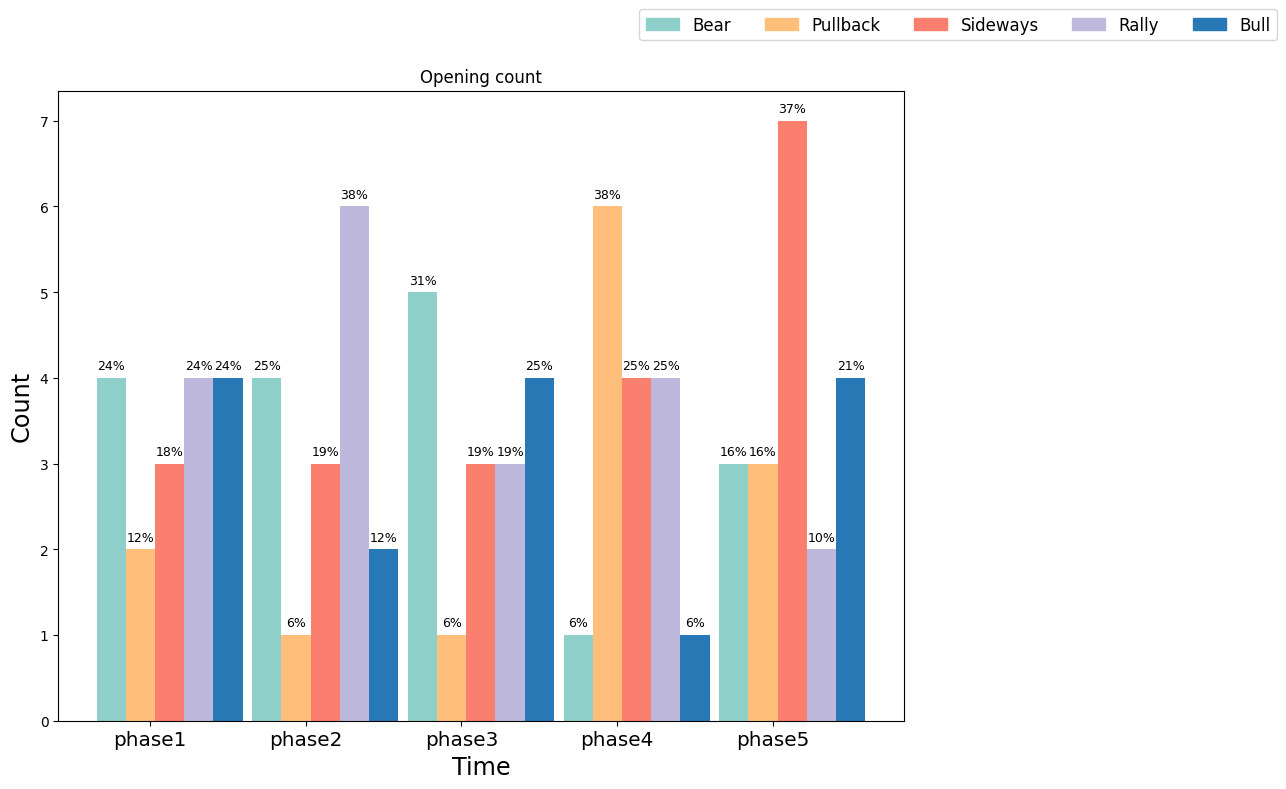

In [25]:
color_list = ["#8ECFC9", "#FFBE7A", "#FA7F6F", "#BEB8DC", "#2878B5"]
x_label = ["phase1", "phase2", "phase3", "phase4", "phase5"]
y_label = ["Bull", "Rally", "Sideways", "Pullback", "Bear"]
y_label.reverse()


x_ax = np.array(range(len(x_label))) * 4

fig = plt.figure(figsize=(24, 18))
# plt.suptitle('Opening/Closing counts/amounts along different time with diff market type')

patches = [
    mpatches.Patch(color=color_list[i], label="{:s}".format(y_label[i]))
    for i in range(len(color_list))
]

ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width, box.height * 0.75])
fig.legend(
    handles=patches,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.93),
    ncol=5,
    fontsize="large",
)

plt.subplot(221)
plt.xlabel("Time", fontsize="xx-large")
plt.ylabel("Count", fontsize="xx-large")
plt.title("Opening count")
for i in range(5):
    plt.bar(
        [m + i * 0.75 for m in x_ax],
        [count[i] for count in opening_count_seg],
        label=y_label[i],
        width=0.75,
        color=color_list[i],
    )
plt.xticks([i + 1 for i in x_ax], x_label, fontsize="x-large")
for i in range(len(opening_count_seg)):
    plotdata = [count[i] for count in opening_count_seg]
    for x, y in enumerate(plotdata):
        plt.text(
            x * 4 + i * 0.75,
            y + 0.1,
            format(opening_count_perc[x][i] * 100, ".0f") + "%",
            ha="center",
            fontsize=9,
        )


img_path = path + "/phase_dynamic_proportion.pdf"
plt.savefig(img_path, bbox_inches="tight")
# plt.show()